In [1]:
import jax 
import ticktack
import matplotlib.pyplot as pyplot
import jupyterthemes

jupyterthemes.jtplot.style()

In [3]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

MATRIX = model._matrix
PROJECTION = model._production_coefficients

del model

In [4]:
def load(filename: str, /, sep: str=","):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        _ = next(data)              # Header row for the data 

        data = jax.numpy.array(
            [row.strip().split(sep) for row in data], 
            dtype=jax.numpy.float64
        )
        
        return data.T

In [5]:
time_out = jax.numpy.linspace(0, 10, 100)

In [6]:
multiply = jax.jit(jax.vmap(jax.numpy.multiply, in_axes=(None, 0)))
matrix_multiply = jax.jit(jax.vmap(jax.numpy.matmul, in_axes=(0, None)))

In [8]:
eigenvals, eigenvecs = jax.numpy.linalg.eig(MATRIX)
eigenvecs, eigenvals = eigenvecs.real, eigenvals.real
inverse = jax.numpy.linalg.inv(eigenvecs)
initial_position = 1.0 / jax.numpy.linalg.norm(PROJECTION) * PROJECTION

In [9]:
@jax.jit
def fundamental_matrix(time_out, /, eigenvecs=eigenvecs, eigenvals=eigenvals, inverse=inverse):
    """
    This constructs the right hand side of the fundamental solution matrix. It is vectorised and so returns a three dimensional array with the third dimension spanning the time series implied by `time_out`.

    Parameters:
    -----------
    : time_out :  The time series over which the fundamental matrix is to be calculated
    : eigenvecs : The eigenvectors of the transfer matrix
    : eigenvals : The eigenvalues of the transfer matrix
    : inverse : The inverse of the eigenvectors of the transfer matrix. This could be calculated internally but since the evaluation is only required once it is passed as an argument.

    Returns:
    --------
    : DeviceArray : The fundamental solution matrix evaluated over the time series implied by `time_out`
    """
    # So I need to implement the translation of the time series back onto 0
    exponents = jax.numpy.exp(multiply(eigenvals, time_out))
    transition_matrix = multiply(eigenvecs, exponents)
    transition_matrix = matrix_multiply(transition_matrix, inverse)
    return transition_matrix

In [10]:
@jax.jit
def analytic_template(time_out, /, initial_poisition=initial_position):
    """
    Determines the analytic solution of an impulse response function over the time series provided by `time_out`.

    Parameters:
    -----------
    : time_out : The time series at which the analytic solution is to be evaluated
    : inverse : The inverse of the eigenvectors of the transfer matrix
    
    """
    transition_matrix = fundamental_matrix(time_out - time_out.min())
    return matrix_multiply(transition_matrix, initial_poisition)

In [11]:
intcal = load("/home/jordan/Documents/ticktack/src/data/datasets/IntCal20/Intcal20.csv")

In [12]:
@jax.jit
def design_matrix(time_series):
    """
    Constructs the design matrix of the linear regression. 
    
    Parameters:
    -----------
    : time_series : The time over which to evaluate the design matrix.
    
    Returns:
    --------
    : DeviceArray : A 3 by n matrix where n is the length of `time_series`.
    """
    constant = jax.numpy.ones((time_series.shape), dtype=jax.numpy.float64)
    # So I think that the prescence of the zero values is going to cause problems
    # I need to look into the `jax.lax.dynamic_slice_update()` to fix this.
    temporal = (time_series - time_series.min()) / time_series.ptp()
    analytic = analytic_template(time_series)[:, 1]
    return jax.numpy.stack([constant, temporal, analytic])

In [15]:
@jax.jit
def regression(start, size, /, data=None):
    """
    This performs a linear regression of the basis vectors.
    
    Parameters:
    -----------
    : start : The start year to begin the regression.
    : size : The length of the sliding window.
    : data : The data set the sliding regression is done on.
    
    Returns:
    --------
    : Array : The parameters of the regression 
    """
    in_window = (data[0] > start) & (data[0] < start + size)
    # I choose to repeat the first appearing data point as this 
    # will not affect the computation. If it is computationally efficient than I 
    # can use jax.numpy.unique() to filter the array
    # Alternatively I could multiply an jax.numpy.arange by the in_window 
    # and take the minimum of this.
    index_list = jax.numpy.arange(in_window.size)
    masked_indices = index_list * in_window
    masked_indices += masked_indices.max() * (1 - in_window)
    first_non_zero = masked_indices.min()
    fill_value = data[:, first_non_zero].reshape(-1, 1)
    fill_value = jax.numpy.tile(fill_value, in_window.size)

    masked_data = jax.numpy.where(in_window, data, fill_value)
    #! I need to take this apart line by line outside a function and test that it 
    # works.

    # data_in_window = in_window * data
    masked_matrix = design_matrix(masked_data[0])
    lst_square = jax.numpy.linalg.lstsq(masked_matrix.T, masked_data[1].reshape(-1, 1))
    lst_square = lst_square[0].reshape(-1)
    # So this is all working 

    model = matrix_multiply(masked_matrix.T, lst_square)
    chi_squared = jax.numpy.sum((masked_data[1] - model) ** 2 / masked_data[2] ** 2)
    return jax.numpy.hstack([lst_square, chi_squared])

In [32]:
time_series = jax.numpy.sort(intcal[0])

In [35]:
parameters = jax.numpy.array([
    regression(start, 50, data=intcal) for start in time_series
])

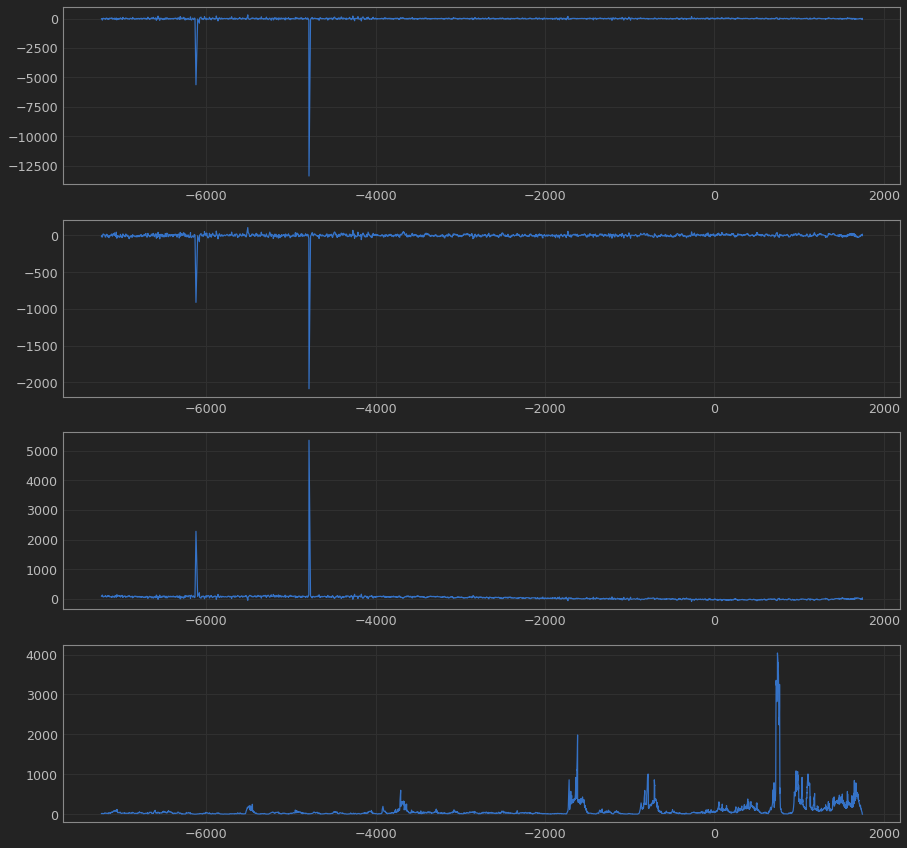

In [38]:
figure, axes = pyplot.subplots(4, 1, figsize=(15, 15))
axes[0].plot(time_series, parameters[:, 2])
axes[1].plot(time_series, parameters[:, 1])
axes[2].plot(time_series, parameters[:, 0])
axes[3].plot(time_series, parameters[:, 3])

In [16]:
test_sample = load("miyake12.csv", sep=" ")

In [186]:
%%timeit
test_parameters = jax.numpy.array(
    [regression(year, 25, data=test_sample) for year in test_sample[0]]
)

7.69 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


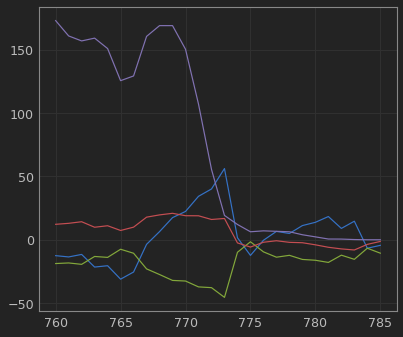

In [18]:
pyplot.plot(test_sample[0], test_parameters[:, 2])
pyplot.plot(test_sample[0], test_parameters[:, 0])
pyplot.plot(test_sample[0], test_parameters[:, 1])
pyplot.plot(test_sample[0], test_parameters[:, 3])

So the next challenge is to plot all of the fit's to check that things make sense. It might be a better design to move all of the hard coding into the design matrix function instead of keeping it in regression. This will improve the outlook I think.

In [28]:
# This cell will generate the design matrixes by vmap the masking function 
# and then the design matrix function. The output should then be a 3 dimensional 
# array that can be plotted after I matrix_multiply that son of a bitch 
@jax.jit
@jax.vmap
def in_window(start, /, data=test_sample, size=10):
    return (data[0] >= start) & (data[0] < start + size)

In [283]:
vec_mat = jax.jit(jax.vmap(design_matrix)) # Vectorising the deisgn matrix command
vec_reg = jax.jit(jax.vmap(jax.numpy.linalg.lstsq)) # Vectorising the lstq function 
vec_matmul = jax.jit(jax.vmap(jax.numpy.matmul))

In [193]:
@jax.jit
def vec_reg(data, /, size: int=10):
    start = data[0, :-10] # Storing as a variable for the usefulness 
    mask = in_window(start)      # Creates a boolean mask of out of date

    indices = jax.numpy.arange(start.size) # Inex entry points to get a fill value
    fill_values = jax.numpy.take(data, indices, axis=1) # Data sliced along dimension
    fill_values = fill_values.repeat(data[0].size) # Element wise repetition
    fill_values = fill_values.reshape(3, -1, data[0].size)

    data = test_sample.tile(start.size)
    data = data.reshape(3, -1, data[0].size)

    # The error is here. Where is not pulling the correct data out
    masked_data = jax.numpy.where(mask, data, fill_values)
    masked_matrix = vectorized_mat(masked_data[0]) # Building the design matrixes

    input_arr = jax.numpy.transpose(masked_matrix, axes=(0, 2, 1))
    lst_square = vec_reg(input_arr, masked_data[1])[0]

    models = vec_matmul(lst_square, test) # Running the models

So I need to consider using a mask and then non-zero with a size parameter. I can always choose the leading axis to make sure that the data exists. There is a major problem since the time data is not obviously associated we are getting subtraction where there shouldn't be any. Hmmmmmm fuck

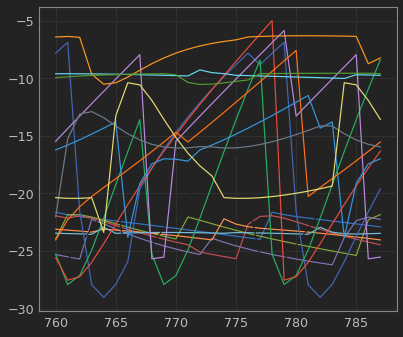

In [365]:
pyplot.plot(test_sample[0], models.T)